In [5]:
import os
import collections

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import torch
from torch import nn
from torch import Tensor
import torch_geometric
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import WebKB
import networkx as nx
from networkx.algorithms import community

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_dir="./data"
os.makedirs(data_dir,exist_ok=True)

In [6]:
dataset=WebKB(root=data_dir,name='texas')

In [7]:
data=dataset[0]

In [8]:
print(f'Number of nodes: {data.num_nodes}')

Number of nodes: 183


In [9]:
print(f'Num of edges: {data.num_edges}')

Num of edges: 325


In [10]:
n_self_loops=0
for i in range(data.num_edges):
    if data.edge_index[0,i]== data.edge_index[1,i]:
        print(f'Self-loop at {data.edge_index[0,i]}')
        n_self_loops+=1
print(n_self_loops)

Self-loop at 13
Self-loop at 15
Self-loop at 34
Self-loop at 45
Self-loop at 67
Self-loop at 73
Self-loop at 86
Self-loop at 90
Self-loop at 95
Self-loop at 102
Self-loop at 134
Self-loop at 148
Self-loop at 156
Self-loop at 163
Self-loop at 175
Self-loop at 180
16


In [11]:
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Has isolated nodes: False
Has self-loops: True
Is undirected: False


In [12]:
edge_index=data.edge_index.numpy()
print(edge_index.shape)

(2, 325)


In [13]:
# lets look at the edge held by the 15th node as an example
index=15
edge_example_outward=edge_index[:,np.where(edge_index[0]==index)[0]]
edge_example_inward=edge_index[:,np.where(edge_index[1]==index)[0]]
edge_example_outward

array([[ 15,  15,  15,  15,  15],
       [ 15,  16,  22,  65, 165]], dtype=int64)

In [14]:
edge_example_inward

array([[ 15,  20,  57,  92, 174],
       [ 15,  15,  15,  15,  15]], dtype=int64)

In [15]:
# lets try to draw a network centered on this node with networkx

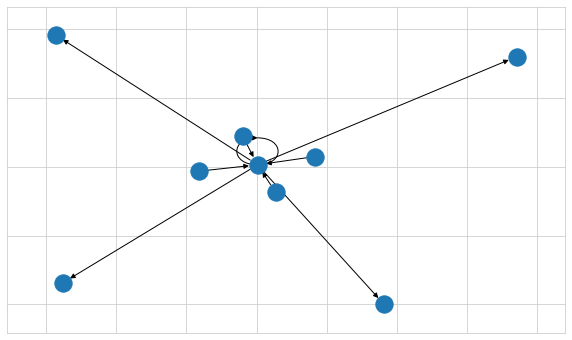

In [16]:
node_example=np.unique(np.concatenate([edge_example_outward.flatten(),edge_example_inward.flatten()]))
plt.figure(figsize=(10,6))
G=nx.DiGraph()
G.add_nodes_from(node_example)
G.add_edges_from(list(zip(edge_example_outward[0],edge_example_outward[1])))
G.add_edges_from(list(zip(edge_example_inward[0],edge_example_inward[1])))
nx.draw_networkx(G,with_labels=False)

In [17]:
print(f'Average node degree: {data.num_edges/data.num_nodes:.2f}')

Average node degree: 1.78


In [18]:
G=to_networkx(data,to_undirected=False)
degrees=[val for (node,val) in G.degree()]
display(pd.DataFrame(pd.Series(degrees).describe()).transpose().round(2))
print(len(degrees))
print(sum(degrees))

,count,mean,std,min,25%,50%,75%,max
0,183.0,3.55,7.93,1.0,1.0,2.0,4.0,104.0


183
650


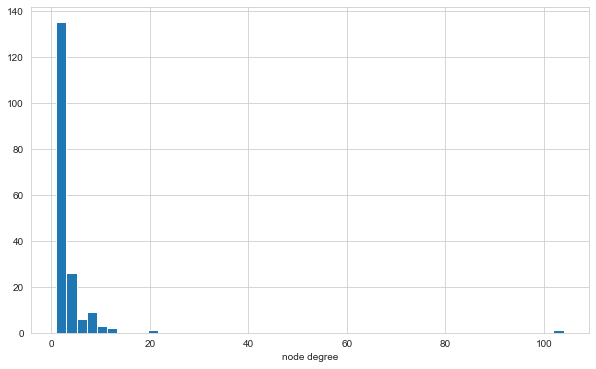

In [19]:
plt.figure(figsize=(10,6))
plt.hist(degrees,bins=50)
plt.xlabel('node degree')
plt.show()

threshold 0.049450549450549455


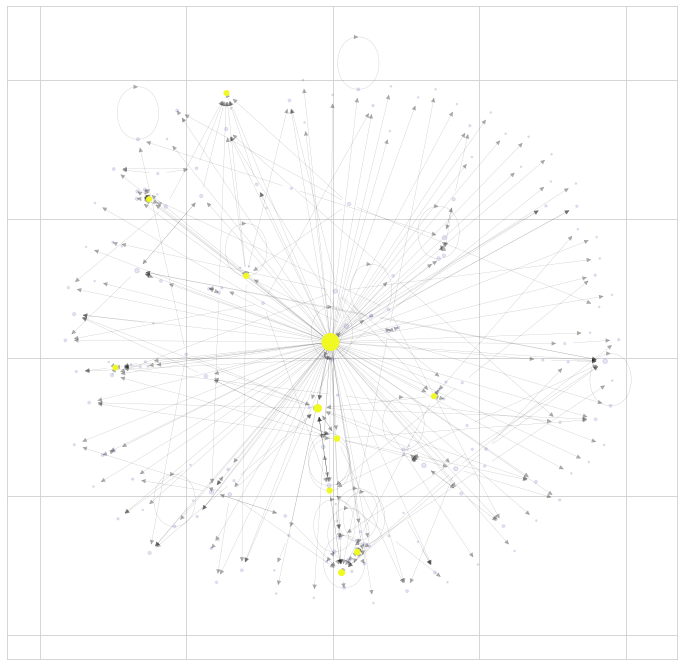

In [20]:
# lets plot the graph to see where the top 10 nodes with the highest degree are located
G=to_networkx(data,to_undirected=False)
pos=nx.spring_layout(G,seed=42)
cent=nx.degree_centrality(G)
node_size=list(map(lambda x:x*500,cent.values()))

cent_array=np.array(list(cent.values()))
threshold=sorted(cent_array,reverse=True)[10]
print("threshold",threshold)
cent_bin=np.where(cent_array>=threshold,1,0.1)

plt.figure(figsize=(12,12))
nodes=nx.draw_networkx_nodes(G,pos,node_size=node_size,cmap=plt.cm.plasma,node_color=cent_bin,nodelist=list(cent.keys()),alpha=cent_bin)
edges=nx.draw_networkx_edges(G,pos,width=0.25,alpha=0.3)
plt.show()


In [21]:
print(f'Number of features: {data.num_node_features}')

Number of features: 1703


In [22]:
# let's display some of the features, and you can see that they are composed of 0s and 1s
print(len(data.x[0]))
data.x[1][:20]

1703


tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
        0., 0.])

In [23]:
print(f'Number of edge features: {data.num_edge_features}')

Number of edge features: 0


In [24]:
# this papers in the Texas dataset are labeled with 5 different labels
print(f'Number of classes: {dataset.num_classes}')

Number of classes: 5


In [25]:
label_dict={
    0:"student",
    1:"project",
    2:"course",
    3:"staff",
    4:"faculty"}

data.y[:10]

tensor([3, 0, 2, 3, 4, 3, 0, 0, 3, 0])

In [26]:
# let's find out the number of each class
counter=collections.Counter(data.y.numpy())
counter=dict(counter)
print(counter)

{3: 101, 0: 33, 2: 18, 4: 30, 1: 1}


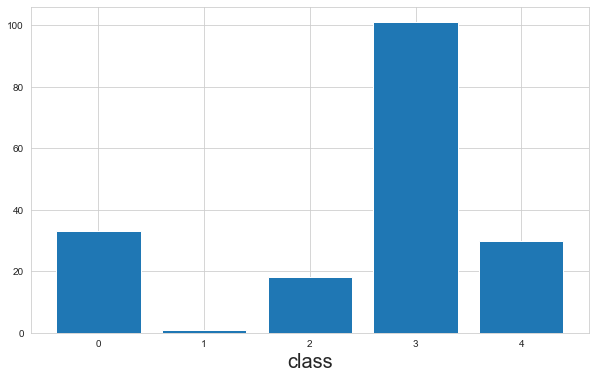

In [27]:
count=[x[1] for x in sorted(counter.items())]
plt.figure(figsize=(10,6))
plt.bar(range(5),count)
plt.xlabel("class",size=20)
plt.show()

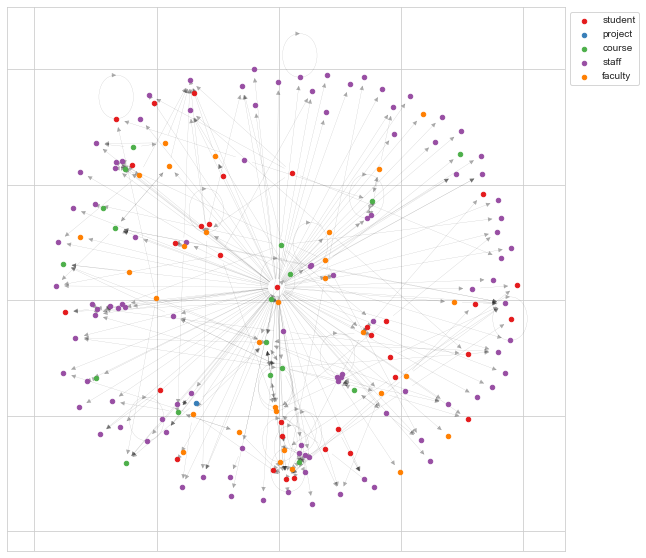

In [29]:
G=to_networkx(data,to_undirected=False)
node_color=[]
nodelist=[[],[],[],[],[]]
colorlist=['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00']
labels=data.y
for n,i in enumerate(labels):
    node_color.append(colorlist[i])
    nodelist[i].append(n)

pos=nx.spring_layout(G,seed=42)
plt.figure(figsize=(10,10))
labellist=list(label_dict.values())

for num,i in enumerate(zip(nodelist,labellist)):
    n,l=i[0],i[1]
    nx.draw_networkx_nodes(G,pos,nodelist=n,node_size=20,node_color=colorlist[num],label=l)
nx.draw_networkx_edges(G,pos,width=0.2,alpha=0.3)
plt.legend(bbox_to_anchor=(1,1),loc='upper left')


In [30]:
# from above, it seems that the nodes are not connected to each other in the same class, we will analyze this point from different angle in the next section


In [31]:
# Homophily and Heterophily
# Nodes with the same characteristics are other connected. This property is called homophily and the opposite is called heterophily.For the five class we looked at earlier, we will see how many nodes of the same class are connected by edges or vice versa.

In [ ]:
labels=data.y.numpy()
connected_labels_set=list(map(lambda x: labels[x]))
